# To-Do 
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  



make extra figures into a separate document  
put stats under header for each type of analysis  
put MRS analysis in different document

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# DATAFRAME SETUP AND FUNCTIONS
___

In [2]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures'

In [3]:
# Creates dataframes of all trials and all bigrams collected across all subjects

# Getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)

# Looping through selected subject folders, getting appropriate paths to data, 
# and making sID list (only includes subjects selected for manuscript 1)
sub_folders_turbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['with_turbo'])
all_bytrial = []
all_bybigram = []
ID_list = []
for sub in sub_folders_turbo:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

# Makes list of folders for subjects without turbo typing data
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/'\
                 'not_used/no_turbotyping/'
os.chdir(server_noturbo)
sub_folders_noturbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['without_turbo'].dropna())

# Gets data from subjects without turbo typing
for sub in sub_folders_noturbo:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial.append(bytrial)
    all_bybigram.append(bybigram)
    ID_list.append(sID)

# Concatenating all trial-based dataframes
all_trials = pd.concat(all_bytrial).reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 
                                        'trial_num', 
                                        'rep_num']).reset_index(drop = True)

# Adding IKI columns
all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], 
                       axis = 1)

# Changing column names to identify they are IKI values
change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

# Concatenating all bigram-based dataframes
all_bigrams = pd.concat(all_bybigram).reset_index(drop=True)
all_bigrams = all_bigrams.sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 
                                          'trial_num', 
                                          'rep_num', 
                                          'bigram_loc'])

# Sorting ID list by ascending value
ID_list.sort()

12


In [4]:
# Checking how many participants
len(ID_list)

37

In [5]:
# Gets rid of runtime error about invalid division
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
# # Function to filter dataframes by correct or incorrect trial or bigrams
# def corr_filter(dataframe, tri_or_bg, corr_or_incorr):
#     if (tri_or_bg == 'tri') and (corr_or_incorr == 'corr'):
#         DF = (dataframe[dataframe.string 
#                == dataframe.resp_string]).reset_index(drop=True)
#     elif (tri_or_bg == 'tri') and (corr_or_incorr == 'incorr'):
#         DF = (dataframe[dataframe.string 
#                  != dataframe.resp_string]).reset_index(drop=True)
#     elif (tri_or_bg == 'bg') and (corr_or_incorr == 'corr'):
#         DF = (all_bigrams[all_bigrams.bigram 
#             == all_bigrams.resp_bigram]).reset_index(drop=True)
#     elif (tri_or_bg == 'bg') and (corr_or_incorr == 'incorr'):
#         DF = (all_bigrams[all_bigrams.bigram 
#               != all_bigrams.resp_bigram]).reset_index(drop=True)
#     else: print('''Please write "tri" or "bg" for tri_or_bg variable and/or
#                 "corr" or "incorr" for corr_or_incorr variable.''')
        

In [7]:
# Making filtered dataframes by errors
corr_trials = (all_trials[all_trials.string 
               == all_trials.resp_string]).reset_index(drop=True)
incorr_trials = (all_trials[all_trials.string 
                 != all_trials.resp_string]).reset_index(drop=True)

corr_trials_bybg = (all_bigrams[all_bigrams.string 
                    == all_bigrams.resp_string]).reset_index(drop=True)
incorr_trials_bybg = (all_bigrams[all_bigrams.string 
                      != all_bigrams.resp_string]).reset_index(drop=True)

# Excludes only incorrect bigrams 
corr_bgs = (all_bigrams[all_bigrams.bigram 
            == all_bigrams.resp_bigram]).reset_index(drop=True) 
incorr_bgs = (all_bigrams[all_bigrams.bigram 
              != all_bigrams.resp_bigram]).reset_index(drop=True)

corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

# Making dataframe with only correct trials that have ikis 
# within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) 
                     & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

# Making dataframe with only correct bigrams that have ikis 
# within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
# Making dataframe with both correct and incorrect bigrams 
# that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

In [8]:
## These need to be edited to include changable dataframe like the other functions

## SEE IF THESE CAN BE USED BY OTHER FUNCTIONS

def indiv_meanikis_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

In [9]:
# indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')

In [10]:
# Calculates all IKI metrics for each individual across all frequency groups of 
# a given type.
def indiv_ikimetric(dataframe, str_or_bg, typ_group_list, metric_list):
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        metrics = DF.groupby(['sID', str_or_bg]).IKI.agg(metric_list)
        mean_metrics = pd.DataFrame(metrics.groupby('sID').agg('mean'))
        # for metric in metric_list:
        #     mean_metrics = mean_metrics.rename(columns = {metric.__name__:
        #                                         '{}_IKI'.format(metric.__name__)})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                mean_metrics['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                mean_metrics['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             mean_metrics['bf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, mean_metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    return all_metrics.reset_index()

# Lists typingmod groups of bigram and word frequency types
bf_groups = ['lowbf', 'medbf', 'highbf']
avgbf_groups = ['avg_lowbf', 'avg_medbf', 'avg_highbf']
wf_groups = ['pseudo', 'lowwf', 'medwf', 'highwf']

# Lists calculations for iki metrics
iki_metrics = [stat.mean, stat.stdev, variation] ## edit here for more metrics

# Creates dataframes of IKI metric values for bigram, average bigram, and word
# frequency.
all_bybf = indiv_ikimetric(corr_trials_bybg, 'bigram', bf_groups, iki_metrics)
all_byavgbf = indiv_ikimetric(corr_trials_bybg, 'string', avgbf_groups, iki_metrics)
all_bywf = indiv_ikimetric(corr_trials_bybg, 'string', wf_groups, iki_metrics)

In [11]:
all_bywf

sID  mean_IKI    sd_IKI    cv_IKI wf_type
0    s009  0.153669  0.064907  0.419010  pseudo
1    s020  0.184692  0.104068  0.560995  pseudo
2    s175  0.218137  0.103801  0.449944  pseudo
3    s176  0.203003  0.086515  0.411033  pseudo
4    s178  0.163402  0.123761  0.659756  pseudo
..    ...       ...       ...       ...     ...
143  s304  0.117039  0.026847  0.222411    high
144  s305  0.126528  0.034568  0.263171    high
145  s306  0.160863  0.048787  0.292752    high
146  s309  0.175040  0.057643  0.306841    high
147  s311  0.084618  0.025490  0.295131    high

[148 rows x 5 columns]

In [12]:
## Making dataframe of IKI stats by bigram
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [13]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [14]:
## making lists of bigrams without bigrams with repeated letters
# med_reps = ['ll', 'ee', 'oo', 'pp']    
# medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

# low_reps = ['dd', 'kk']
# lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

In [15]:
# corr_trials_bybg.groupby('wf_type').IKI.count()

corr_trials_bybg[corr_trials_bybg['IKI'] >= 1].groupby('bf_type').count()

sID  bigram_num  trial_num  rep_num  bigram_loc  bigram  resp_bigram  \
bf_type                                                                         
high      12          12         12       12          12      12           12   
low       28          28         28       28          28      28           28   
med        4           4          4        4           4       4            4   

         IKI  string  resp_string  bg_freq  meanbf_type  wf_type  trial_corr  \
bf_type                                                                        
high      12      12           12       12           12       12           7   
low       28      28           28       28           28       28          21   
med        4       4            4        4            4        4           4   

         bg_corr  
bf_type           
high           7  
low           21  
med            4

In [16]:
# Defining functions that calculate indivdual mean of mean IKIs, mean CVs, and 
# mean SDs by word and bigram groupings.

# For all the following functions:
  # 'dataframe' needs to be sorted by bigram.
  # 'str_or_bg' can be 'string' or 'bigram'.
  # 'typ_group' needs to be the name of the bigram or word frequency grouping in
  # the typ module as a string.

# Calculates indidivudal mean of mean IKIs for a defined bigram or
# word frequency type.
## FIX TO CALCULATE MEAN OF MEANS ###
def indiv_meanikis(dataframe, str_or_bg, typ_group): 
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means = means.reset_index().rename(columns = {'mean':'Avg IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            means['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            means['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        means['bf_type'] = freq_type
    return means

# Calculates indidivudal mean CV IKIs for a defined bigram or word 
# frequency type.
def indiv_cvikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs = avg_cvs.reset_index().rename(columns = {'mean':'Avg CV IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_cvs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_cvs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_cvs['bf_type'] = freq_type
    return avg_cvs

# Calculates indidivudal mean SD IKIs for a defined bigram or word 
# frequency type.
def indiv_sdikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean']))
    avg_sds = avg_sds.reset_index().rename(columns = {'mean':'Avg SD IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_sds['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_sds['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_sds['bf_type'] = freq_type
    return avg_sds

# Calculates indidivudal total incorrect trial count for a defined bigram or 
# word frequency type.
def indiv_error(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    else:
        print('please write "string" or "bigram" for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size())
    errs = errs.reset_index().rename(columns = {0:'Total Error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            errs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            errs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        errs['bf_type'] = freq_type
    return errs

# Function that adds all individual mean, CV, or SD IKI to one dataframe.
# Requires the use of the above 'indiv_' functions for 'metric_func'.
def all_ikimetric(metric_func, dataframe, str_or_bg, typ_group_list):
    # Use above lists for typ_group_list
    all_metric = pd.DataFrame()
    for group in typ_group_list:
        metric = metric_func(dataframe, str_or_bg, group)
        all_metric = pd.concat([all_metric, metric], ignore_index=True)
    return all_metric

# STATS
___

In [17]:
# high_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')
# high_iki['bf_type'] = 'high'
# med_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')
# med_iki['bf_type'] = 'med'
# low_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')
# low_iki['bf_type'] = 'low'

# print(stat.stdev(high_iki['Avg IKI']))
# print(stat.stdev(med_iki['Avg IKI']))
# print(stat.stdev(low_iki['Avg IKI']))

## Other Stats

In [18]:
# def rank_diff(dataframe, str_or_bg, sort_type, rank1, rank2):

In [19]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf').sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf').sort_values(by = 'Avg SD IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_meanikis(tight_bgs, 'bigram', 'highbf')['Avg IKI'], 
#          indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI'])

# ranksums(indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI'],
#          indiv_cvikis(all_bigrams, 'bigram', 'highbf')['Avg CV IKI'])

In [20]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')
skew_df

sID      skew  mean IKI
0   s009  2.188929  0.129063
1   s020  3.478239  0.180121
2   s175  2.812225  0.191252
3   s176  1.621054  0.204156
4   s178  9.766887  0.155502
5   s180  3.704217  0.132674
6   s181  4.930082  0.116986
7   s182  2.506407  0.169157
8   s183  4.123232  0.160179
9   s189  3.283803  0.173022
10  s190  2.493626  0.161795
11  s198  3.385264  0.160854
12  s207  2.617909  0.166396
13  s209  4.833878  0.135731
14  s210  3.535854  0.177614
15  s212  2.794452  0.171122
16  s217  1.813663  0.136216
17  s219  3.658609  0.248666
18  s224  5.852693  0.149656
19  s240  1.503862  0.152921
20  s254  2.458006  0.267684
21  s261  1.657398  0.137923
22  s262  7.257390  0.129549
23  s263  2.918295  0.182596
24  s267  2.525303  0.207722
25  s276  2.076324  0.170538
26  s278  4.843809  0.168783
27  s279  1.463701  0.240455
28  s282  2.383787  0.245906
29  s283  3.170107  0.157842
30  s286  2.911800  0.199737
31  s302  4.369854  0.163238
32  s304  4.977555  0.134372
33  s305  3.514561  0.130664
34  s306  3.367972  0.167156
35  s309  4.015866  0.207001
36  s311  4.171358  0.100838

# Mean IKI
___

## Mean IKI Stastistics

In [21]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'mean_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'mean_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2       eps
0  bf_type      2     72  130.556706  1.123708e-24  0.263346  0.776306


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.148103  0.206029 -0.057925  0.009415 -6.152244  3.950110e-08   
1  high  med  0.148103  0.169963 -0.021860  0.009415 -2.321761  5.703038e-02   
2   low  med  0.206029  0.169963  0.036065  0.009415  3.830483  6.256255e-04   

      cohen  
0 -1.347360  
1 -0.602557  
2  0.860766

In [22]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'mean_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'mean_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc       ng2       eps
0  avgbf_type      2     72  224.041331  1.217207e-31  0.319429  0.706698


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff       se         T       p-tukey  \
0  high  low  0.143750  0.206366 -0.062616  0.00914 -6.850626  1.409198e-09   
1  high  med  0.143750  0.159710 -0.015961  0.00914 -1.746199  1.929156e-01   
2   low  med  0.206366  0.159710  0.046656  0.00914  5.104427  4.269941e-06   

      cohen  
0 -1.535962  
1 -0.452785  
2  1.121003

In [23]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | average bigram frequency
print(pg.rm_anova(all_bywf, 'mean_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'mean_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  34.564735  9.712398e-16  0.089075  0.722383


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.153651  0.181381 -0.027729  0.009274 -2.990113  0.017103   
1  high     med  0.153651  0.162431 -0.008779  0.009274 -0.946674  0.779696   
2  high  pseudo  0.153651  0.182305 -0.028654  0.009274 -3.089786  0.012719   
3   low     med  0.181381  0.162431  0.018950  0.009274  2.043439  0.177073   
4   low  pseudo  0.181381  0.182305 -0.000924  0.009274 -0.099673  0.999644   
5   med  pseudo  0.162431  0.182305 -0.019875  0.009274 -2.143112  0.144556   

      cohen  
0 -0.709760  
1 -0.247524  
2 -0.708203  
3  0.482105  
4 -0.021073  
5 -0.488437

## Mean IKI Figures

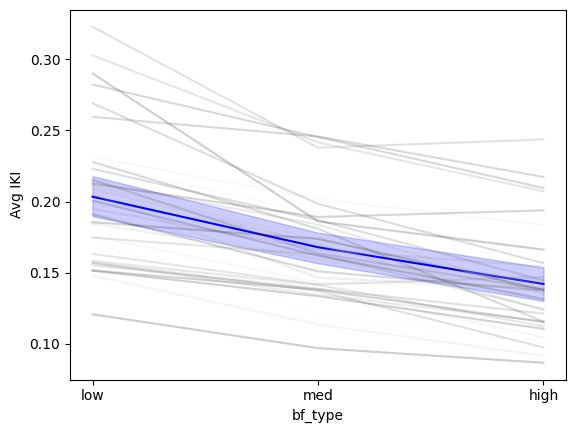

In [24]:
## figure plotting function

def line_chart(metric_func, dataframe, str_or_bg, typ_group_list):
    data = pd.DataFrame()
    for group in typ_group_list:
        datum = metric_func(dataframe, str_or_bg, group)
        data = pd.concat([data, datum])
    # data_df = pd.DataFrame(data)
    return data

test_data = line_chart(indiv_meanikis, corr_trials_bybg, 'bigram', bf_groups)

fig, ax = plt.subplots()
sns.lineplot(data=test_data, x="bf_type", y="Avg IKI", alpha=1, color='blue')
sns.lineplot(data=test_data, x="bf_type", y="Avg IKI", hue='sID', alpha=0.2, 
            palette='gist_yarg', legend=False)
plt.show()

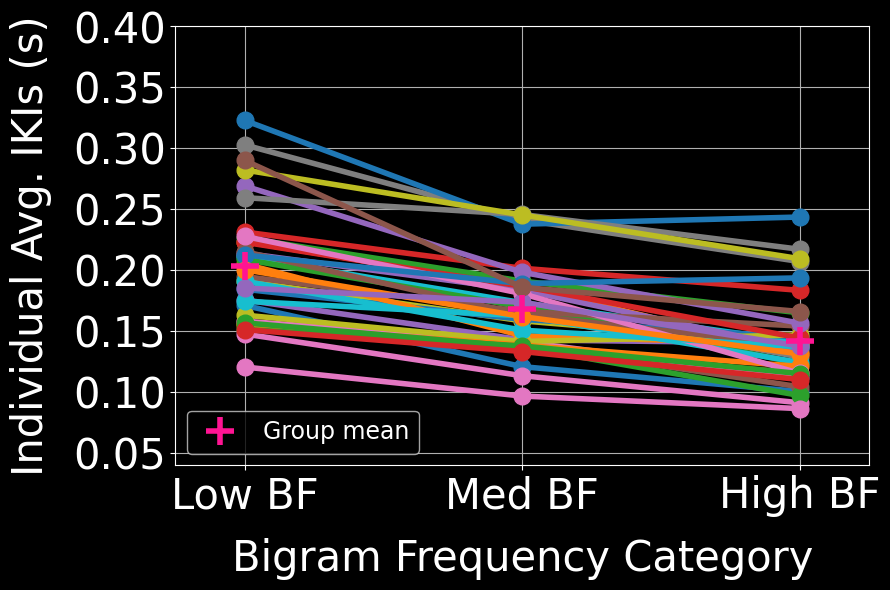

In [25]:
## individual IKI means by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.xlim([1.5, 6.5])
plt.ylim([0.04, 0.4])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15, size=30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

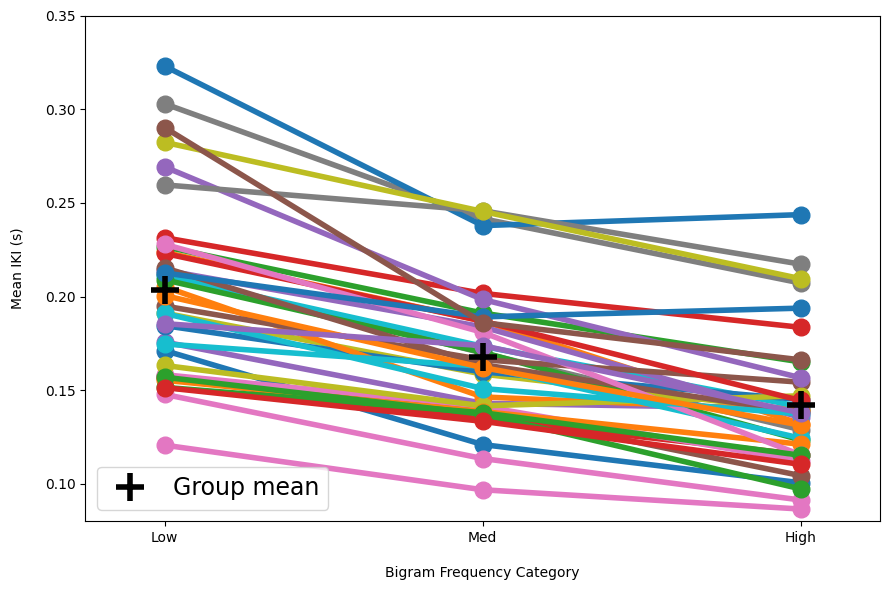

In [26]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

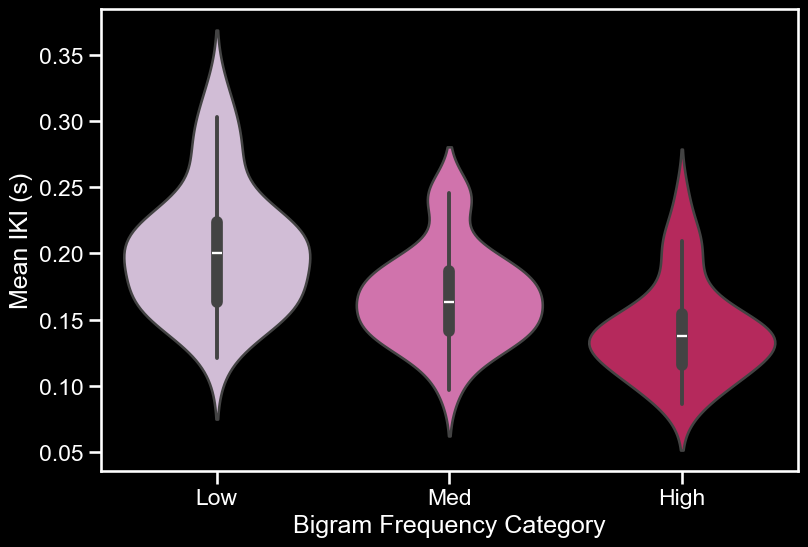

In [27]:
## bigram IKI means by BF (correct trials only)
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Low': indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
        'Med': indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
        'High': indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
# sns.swarmplot(data=(DF.mean().to_frame().T), color='dimgrey', marker='o', size=8)
ax.set(xlabel='Bigram Frequency Category', ylabel='Mean IKI (s)')
# plot.set(title = 'Mean IKI by Bigram Frequency Category')
# plot.set(ylabel='Mean IKI (s)')
# plot.set(xlabel='Bigram Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_bf_corr.png', dpi=300)
plt.show()

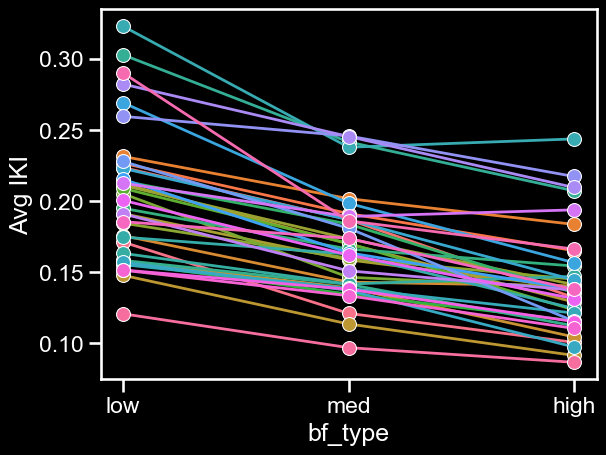

In [28]:
## seaborn version of individuals plot
data = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

ax = sns.lineplot(data=data, x='bf_type', y='Avg IKI', hue='sID', marker = 'o', markersize = 10, linewidth = 2)
ax.get_legend().set_visible(False)
plt.show()

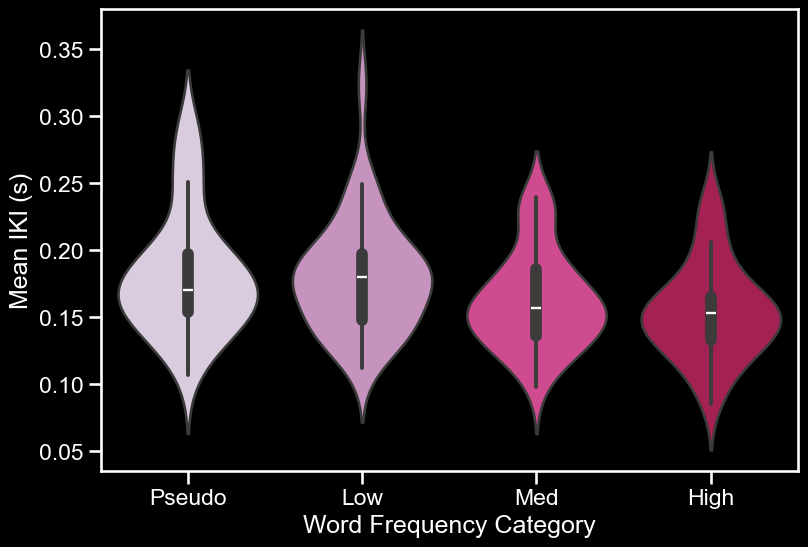

In [29]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Pseudo' : indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
# sns.swarmplot(data=(DF.mean().to_frame().T), color='dimgrey', marker='o', size=8)
ax.set(xlabel='Word Frequency Category', ylabel='Mean IKI (s)')
# plot.set(title = 'Mean IKI by Bigram Frequency Category')
# plot.set(ylabel='Mean IKI (s)')
# plot.set(xlabel='Bigram Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

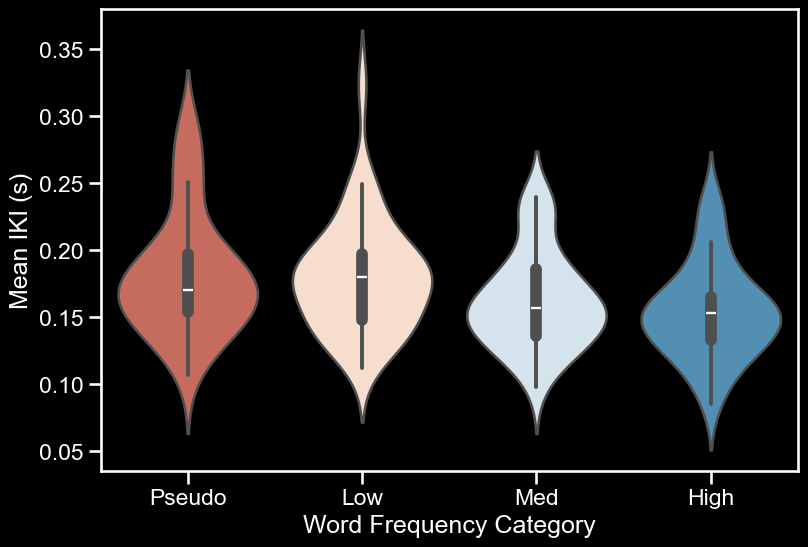

In [30]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Pseudo' : indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='RdBu', ax=ax)
# ax.set(title = 'Mean IKI by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

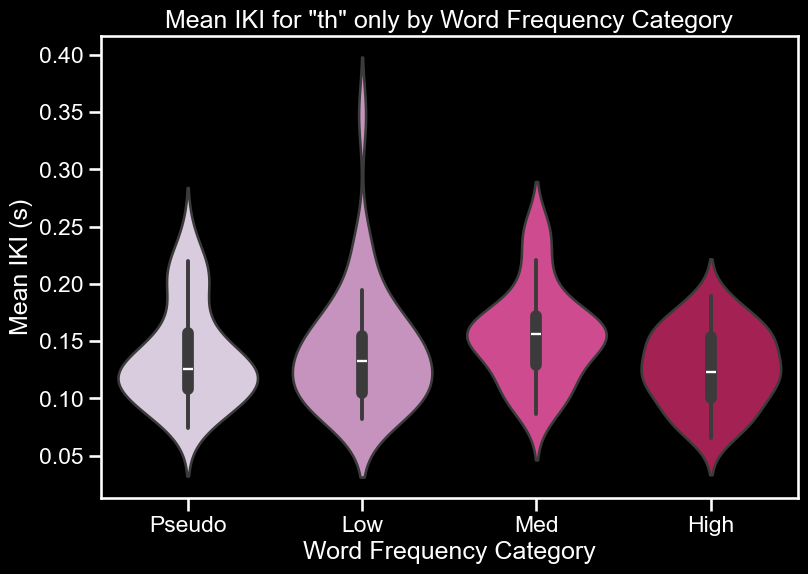

In [31]:
## Mean IKI for 'th' across WF (correct trials only)
# sns.set_style("ticks", rc=custom)
# sns.set_context('talk')
# plt.style.use("dark_background")

th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'he']

data = {'Pseudo' : indiv_meanikis(th_df, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(th_df, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(th_df, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(th_df, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig('violin_meanikis_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

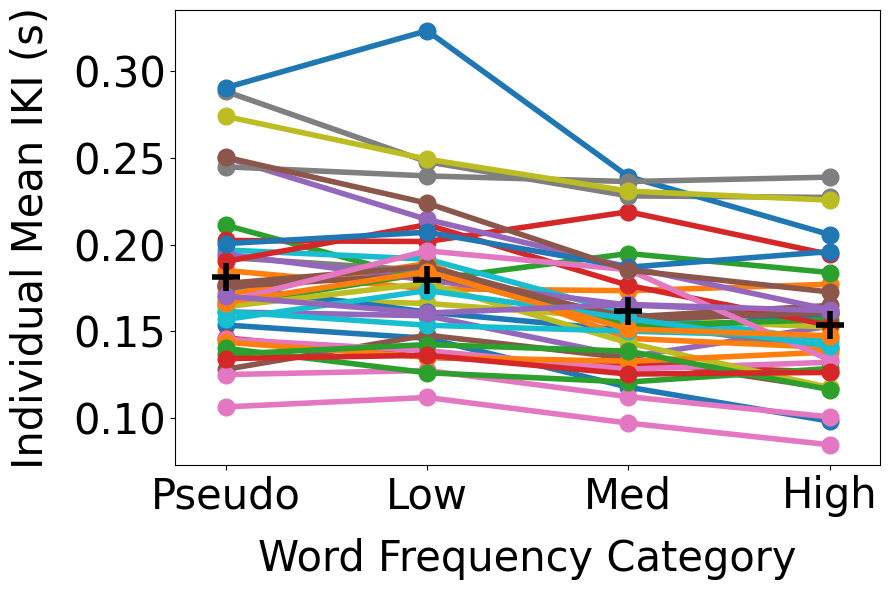

In [32]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
    indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI'])

means = (np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI']),
        np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

In [33]:
np.sqrt(len(corr_trials_bybg.IKI))

181.5378748360793

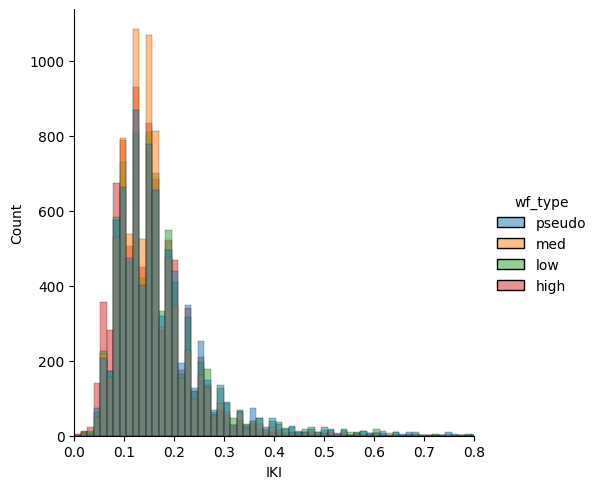

In [34]:
## histograms of mean IKI by WF
# sns.set(rc={"figure.figsize":(9, 6)})
sns.displot(corr_trials_bybg, x='IKI', hue='wf_type', bins=177)
plt.xlim(0, 0.8)
plt.show()

# SD IKI
___

## SD IKI Statistics

In [35]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'sd_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'sd_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2      eps
0  bf_type      2     72  30.144404  3.084168e-10  0.164542  0.78044


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.044794  0.062319 -0.017525  0.004891 -3.583000  0.001473   
1  high  med  0.044794  0.041256  0.003538  0.004891  0.723345  0.750224   
2   low  med  0.062319  0.041256  0.021063  0.004891  4.306345  0.000108   

      cohen  
0 -0.752567  
1  0.186811  
2  1.019571

In [36]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'sd_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'sd_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2          F         p-unc       ng2       eps
0  avgbf_type      2     72  58.715303  7.512156e-16  0.232301  0.862362


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T       p-tukey  \
0  high  low  0.057031  0.095917 -0.038886  0.007082 -5.490664  8.000343e-07   
1  high  med  0.057031  0.066713 -0.009682  0.007082 -1.367076  3.617602e-01   
2   low  med  0.095917  0.066713  0.029204  0.007082  4.123588  2.156370e-04   

      cohen  
0 -1.213706  
1 -0.359906  
2  0.908392

In [37]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | word frequency
print(pg.rm_anova(all_bywf, 'sd_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'sd_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  26.314321  7.453271e-13  0.154376  0.776564


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.056851  0.081899 -0.025048  0.007379 -3.394424  0.004875   
1  high     med  0.056851  0.063973 -0.007121  0.007379 -0.965073  0.769474   
2  high  pseudo  0.056851  0.090159 -0.033308  0.007379 -4.513848  0.000077   
3   low     med  0.081899  0.063973  0.017926  0.007379  2.429352  0.076127   
4   low  pseudo  0.081899  0.090159 -0.008260  0.007379 -1.119424  0.678178   
5   med  pseudo  0.063973  0.090159 -0.026187  0.007379 -3.548776  0.002911   

      cohen  
0 -0.812662  
1 -0.285490  
2 -1.091032  
3  0.544811  
4 -0.221363  
5 -0.802543

## SD IKI Figures

In [38]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     # print(typ.all_bigrams)
    
# repeats = ['ll', 'oo', 'pp', 'dd', 'kk']

# noreps

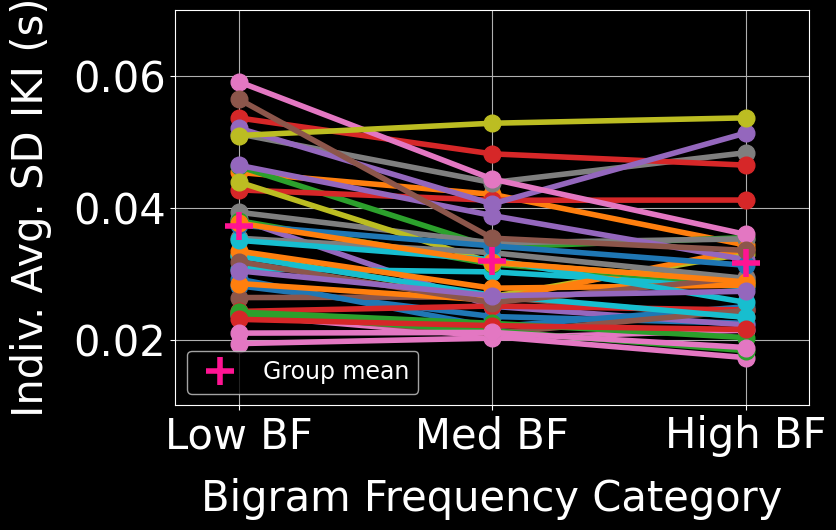

In [39]:
## individual MEAN SD IKI by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI'], 
     indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI'],
     indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI']), 
         np.mean(indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI']),
         np.mean(indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')
ax.set_facecolor('black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.01, 0.07])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Indiv. Avg. SD IKI (s)", labelpad=15, size=30)
plt.grid(visible=None)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

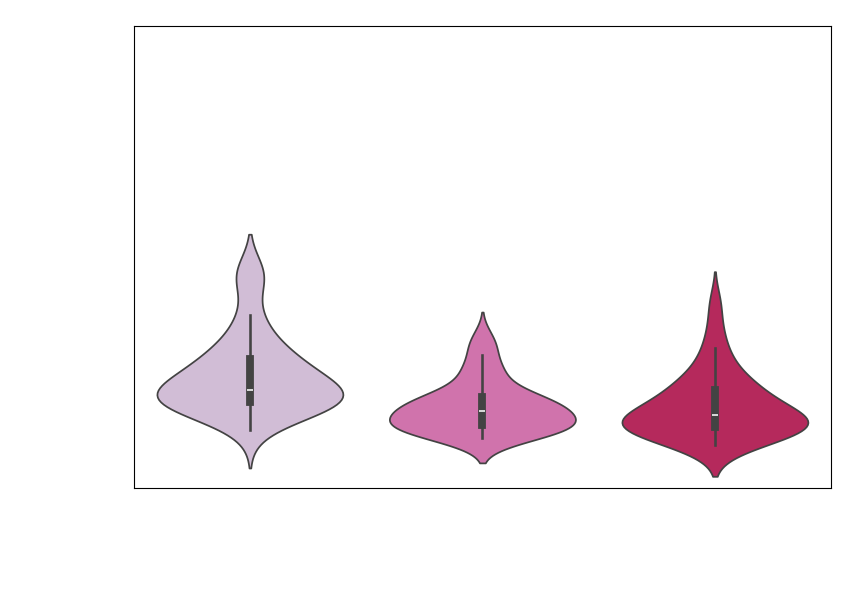

In [40]:
## mean CV IKIs by BF (correct trials only)
data = {'Low': indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf_norep')['Avg SD IKI'], 
        'Med': indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf_norep')['Avg SD IKI'],
        'High': indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
# ax.set(title = 'Mean SD IKI by Bigram Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Bigram Frequency Category')
ax.set_ylim(-0.01, 0.3)

plt.savefig('violin_meansds_bf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

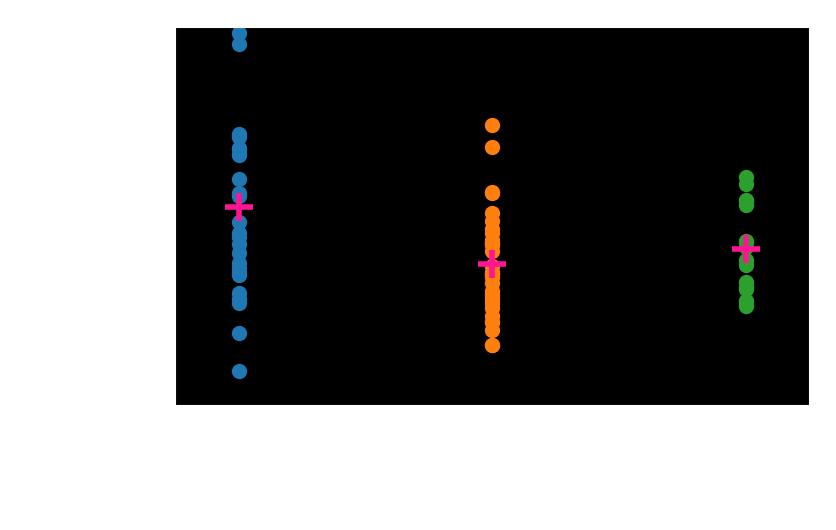

In [41]:
## bigram IKI SDs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['SD'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['SD'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['SD'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['SD']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['SD']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

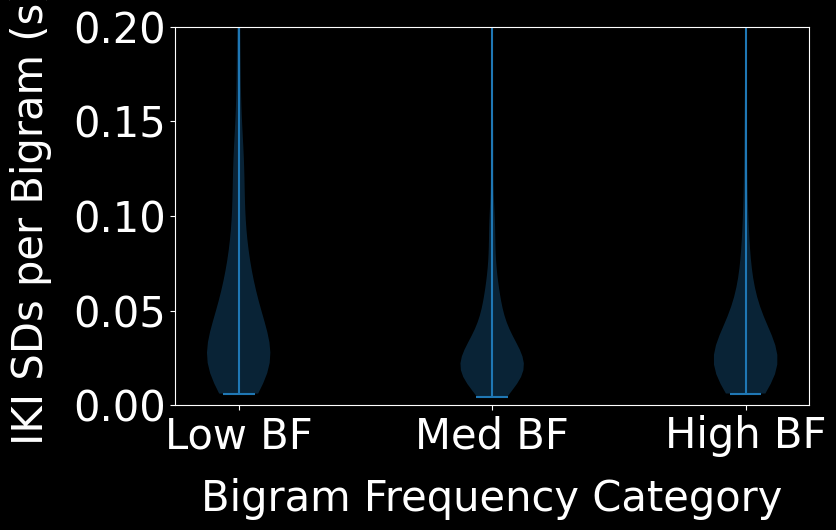

In [42]:
## all bigram IKI SDs for each individual by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D2 = list(sds[sds.bf_type == 'Low']['std'])
# x2 = [2]*len(D2)

# D4 = list(sds[sds.bf_type == 'Med']['std'])
# x4 = [4]*len(D4)

# D6 = list(sds[sds.bf_type == 'High']['std'])
# x6 = [6]*len(D6)

# means = (np.mean(sds[sds.bf_type == 'Low']['std']),
#          np.mean(sds[sds.bf_type == 'Med']['std']),
#          np.mean(sds[sds.bf_type == 'High']['std']))
# xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

D = [list(sds[sds.bf_type == 'Low']['std']),
     list(sds[sds.bf_type == 'Med']['std']),
     list(sds[sds.bf_type == 'High']['std'])]
x = (2, 4, 6)

ax.violinplot(D, x)

plt.ylim([0, 0.2])
plt.xlim([1.5, 6.5])
plt.yticks(size=30)
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'], size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("IKI SDs per Bigram (s)", labelpad=15, size=30)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

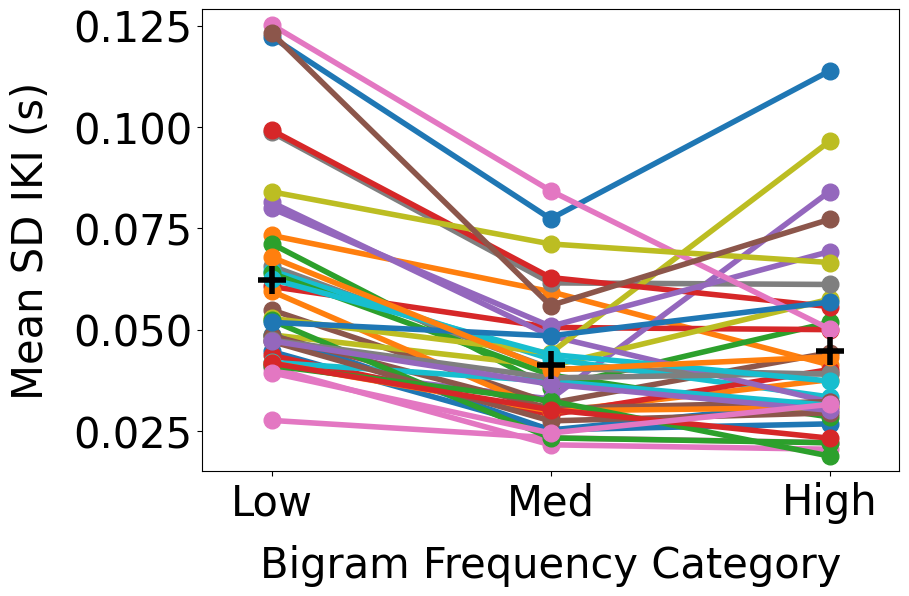

In [43]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI'], 
     indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'],
     indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI']), 
         np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI']),
         np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.015, 0.129])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean SD IKI (s)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_sdikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

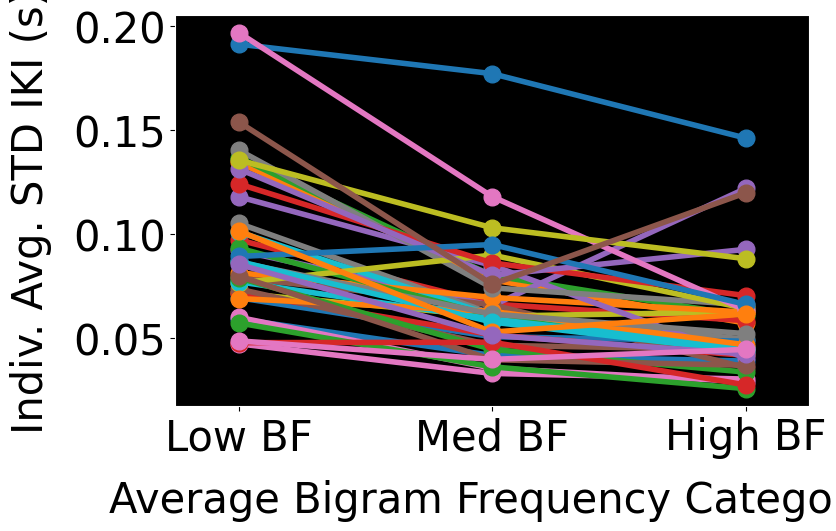

In [44]:
## individual MEAN SD IKI by AVG BF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_sdikis(corr_trials_bybg, 'string', 'avg_lowbf')['Avg SD IKI'], 
     indiv_sdikis(corr_trials_bybg, 'string', 'avg_medbf')['Avg SD IKI'],
     indiv_sdikis(corr_trials_bybg, 'string', 'avg_highbf')['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Average Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_sdikis.png', dpi=300)
plt.show()

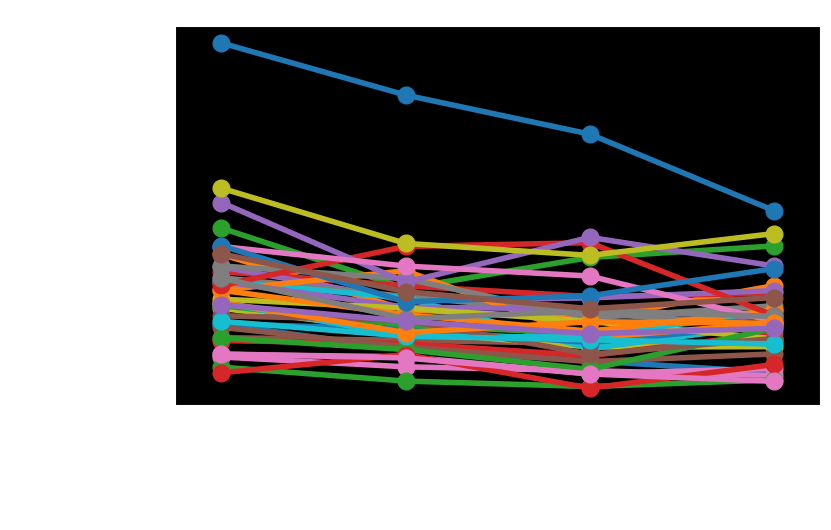

In [45]:
## individual MEAN SD IKI by WF (correct trials)
plt.rcParams['font.size'] = '30'
x = [2, 4, 6, 8]
D = (indiv_sdikis(tight_bgs, 'string', 'pseudo')['Avg SD IKI'], 
     indiv_sdikis(tight_bgs, 'string', 'lowwf')['Avg SD IKI'],
     indiv_sdikis(tight_bgs, 'string', 'medwf')['Avg SD IKI'],
     indiv_sdikis(tight_bgs, 'string', 'highwf')['Avg SD IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
plt.xlabel("Word Frequency Category", labelpad=15)
plt.ylabel("Indiv. Avg. STD IKI (s)", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('indiv_sdikis.png', dpi=300)
plt.show()

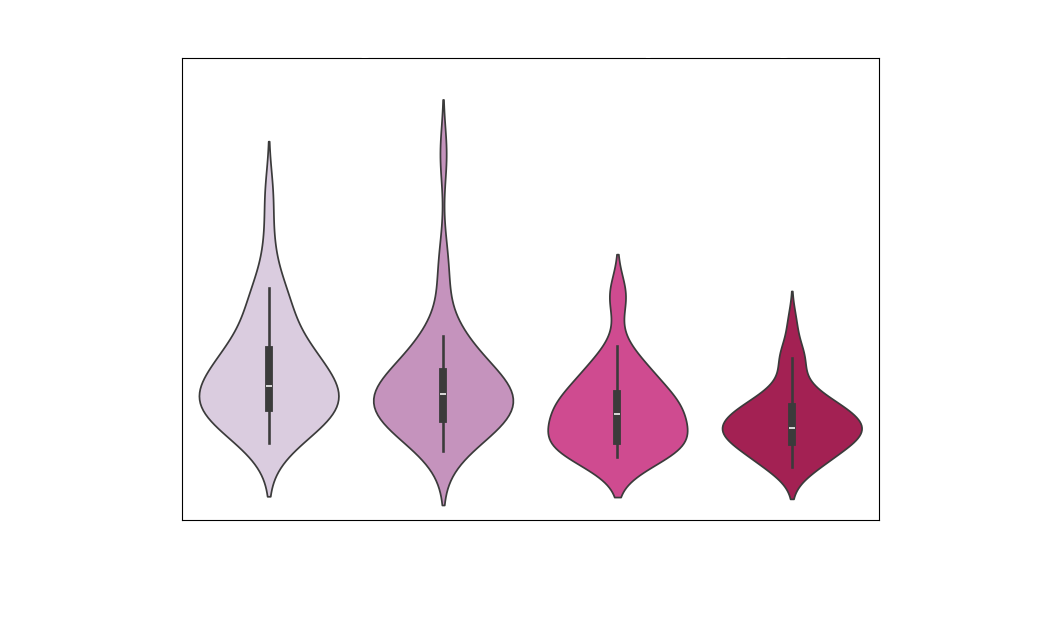

In [46]:
## mean CV IKI by WF (correct trials only)
data = {'Pseudo' : indiv_sdikis(corr_trials_bybg, 'string', 'pseudo')['Avg SD IKI'], 
        'Low': indiv_sdikis(corr_trials_bybg, 'string', 'lowwf')['Avg SD IKI'], 
        'Med' : indiv_sdikis(corr_trials_bybg, 'string', 'medwf')['Avg SD IKI'],
        'High' : indiv_sdikis(corr_trials_bybg, 'string', 'highwf')['Avg SD IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean SD IKI by Word Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.01, 0.3)

plt.savefig('violin_meansds_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

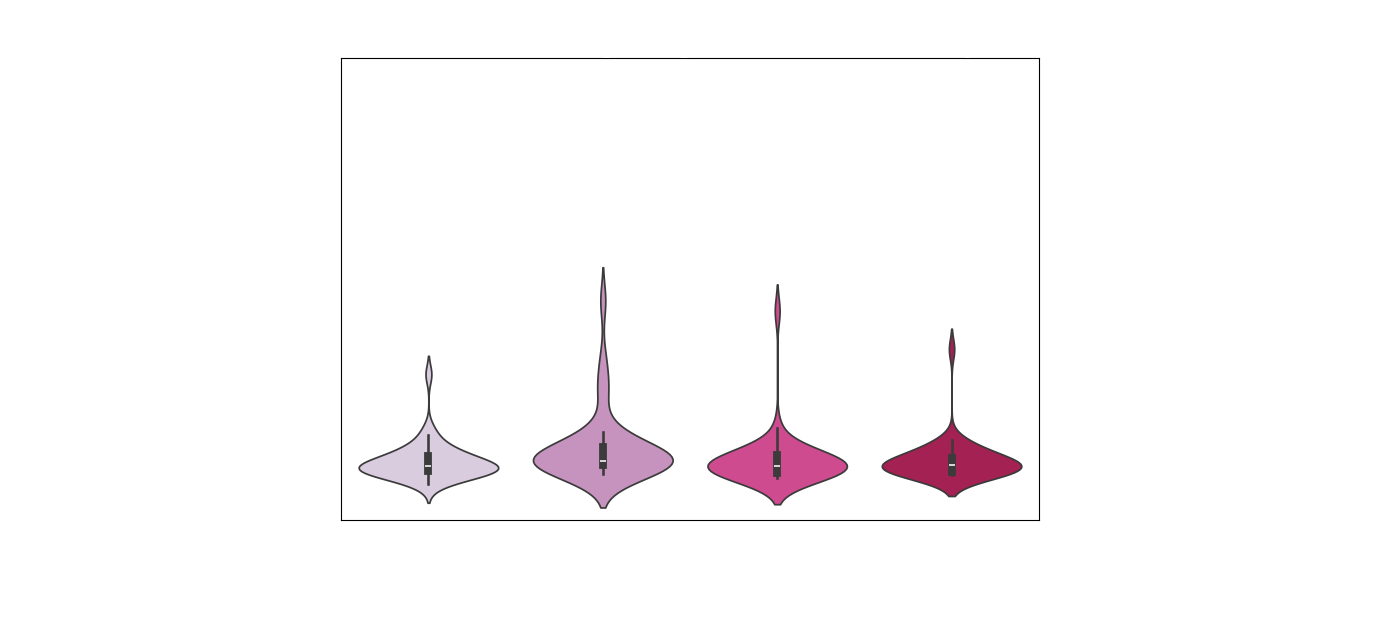

In [47]:
## mean CV IKI for 'th' by WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_sdikis(th_df, 'string', 'pseudo')['Avg SD IKI'], 
        'Low': indiv_sdikis(th_df, 'string', 'lowwf')['Avg SD IKI'], 
        'Med' : indiv_sdikis(th_df, 'string', 'medwf')['Avg SD IKI'],
        'High' : indiv_sdikis(th_df, 'string', 'highwf')['Avg SD IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean SD IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.02, 0.30)

plt.savefig('violin_meansds_thbywf_corr.png', dpi=300)
plt.show()

# CV IKI
___

## CV IKI Statistics

In [48]:
# Runs one-way, repeated measures ANOVA:
# individual CV IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'cv_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'cv_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  bf_type      2     72  20.569648  8.587857e-08  0.139245  0.728137


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.271273  0.263308  0.007965  0.013357  0.596288  0.822401   
1  high  med  0.271273  0.219433  0.051840  0.013357  3.880980  0.000523   
2   low  med  0.263308  0.219433  0.043875  0.013357  3.284692  0.003906   

      cohen  
0  0.126679  
1  0.862167  
2  0.908198

In [49]:
# Runs one-way, repeated measures ANOVA:
# individual mean CV | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'cv_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'cv_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2          F     p-unc       ng2       eps
0  avgbf_type      2     72  11.258097  0.000056  0.067539  0.882972


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.369409  0.434549 -0.065140  0.023317 -2.793639  0.016843   
1  high  med  0.369409  0.399262 -0.029853  0.023317 -1.280301  0.409334   
2   low  med  0.434549  0.399262  0.035287  0.023317  1.513338  0.288707   

      cohen  
0 -0.657369  
1 -0.279025  
2  0.373856

In [50]:
## anova for cvs (by word freq)
print(pg.rm_anova(all_bywf, 'cv_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'cv_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  19.045516  5.493079e-10  1.851034e-08  0.140804   

        eps  sphericity   W-spher   p-spher  
0  0.805394       False  0.662773  0.013952  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.356437  0.412528 -0.056091  0.024602 -2.279943  0.107534   
1  high     med  0.356437  0.370403 -0.013966  0.024602 -0.567665  0.941518   
2  high  pseudo  0.356437  0.464927 -0.108490  0.024602 -4.409805  0.000118   
3   low     med  0.412528  0.370403  0.042125  0.024602  1.712278  0.321078   
4   low  pseudo  0.412528  0.464927 -0.052399  0.024602 -2.129862  0.148600   
5   med  pseudo  0.370403  0.464927 -0.094524  0.024602 -3.842140  0.001037   

      cohen  
0 -0.541095  
1 -0.134244  
2 -0.992325  
3  0.412249  
4 -0.487102  
5 -0.875801

## CV IKI Figures

In [51]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_cvikis(all_bigrams, 'bigram', 'highbf'),
    indiv_cvikis(all_bigrams, 'bigram', 'medbf').rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_cvikis(all_bigrams, 'bigram', 'lowbf').rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

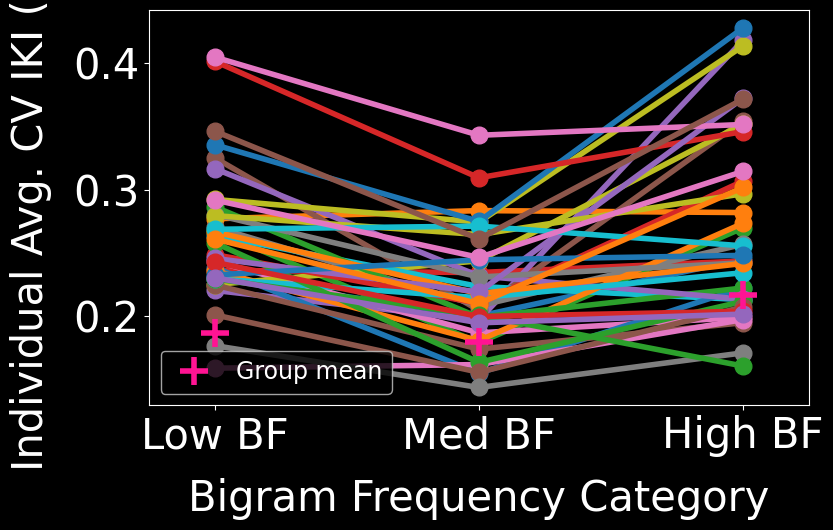

In [52]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(tight_bgs, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size = 30)
plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15, size = 30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

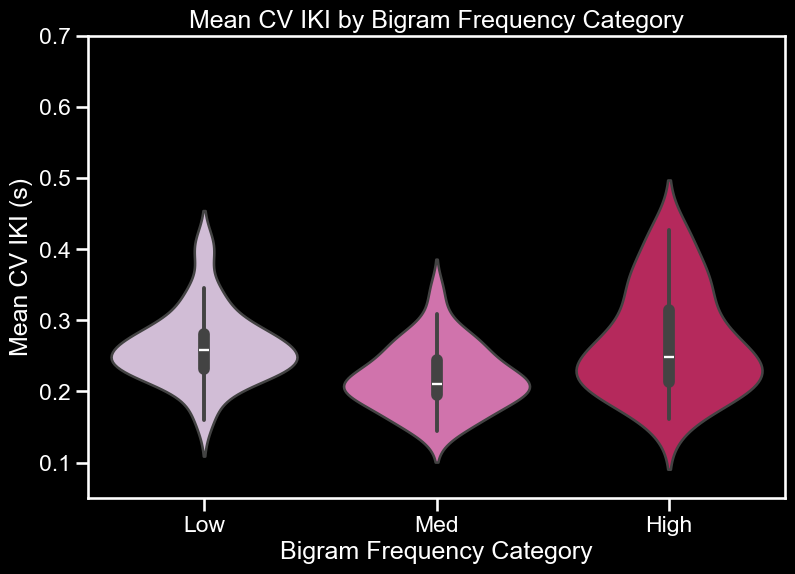

In [53]:
## mean CV IKIs by BF (correct trials only)
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

data = {'Low': indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
        'Med': indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'],
        'High': indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))

# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI by Bigram Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Bigram Frequency Category')
ax.set_ylim(0.05, 0.7)

plt.savefig('violin_meancvs_bf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

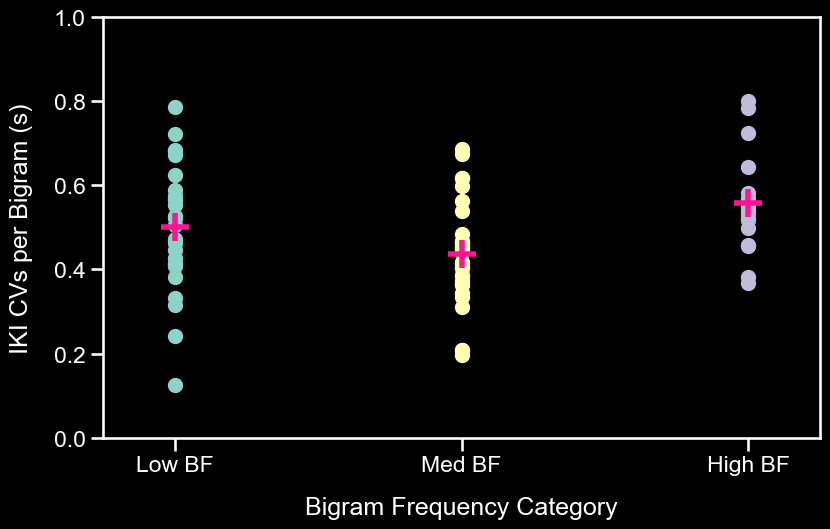

In [54]:
## bigram IKI CVs across individuals by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

# D = (bg_stats[bg_stats.bf_type == 'high']['Mean'],
#      bg_stats[bg_stats.bf_type == 'med']['Mean'],
#      bg_stats[bg_stats.bf_type == 'low']['Mean'])

D2 = list(bg_stats[bg_stats.bf_type == 'low']['CV'])
x2 = [2]*len(D2)

D4 = list(bg_stats[bg_stats.bf_type == 'med']['CV'])
x4 = [4]*len(D4)

D6 = list(bg_stats[bg_stats.bf_type == 'high']['CV'])
x6 = [6]*len(D6)

# mean1 = np.mean(bg_stats[bg_stats.bf_type == 'high']['Mean'])

means = (np.mean(bg_stats[bg_stats.bf_type == 'low']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'med']['CV']),
         np.mean(bg_stats[bg_stats.bf_type == 'high']['CV']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x2, D2, '.', ms = 20)
ax.plot(x4, D4, '.', ms = 20)
ax.plot(x6, D6, '.', ms = 20)
    
ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 1])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

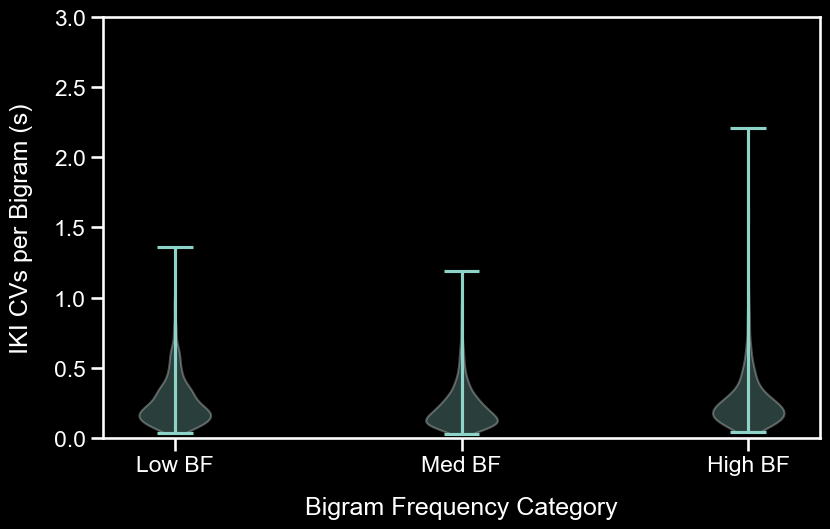

In [55]:
## all bigram IKI CVs for each individual by BF (correct trials only)
plt.rcParams['font.size'] = '30'
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

D2 = list(cvs[cvs.bf_type == 'Low']['variation'])
x2 = [2]*len(D2)


D4 = list(cvs[cvs.bf_type == 'Med']['variation'])
x4 = [4]*len(D4)

D6 = list(cvs[cvs.bf_type == 'High']['variation'])
x6 = [6]*len(D6)

means = (np.mean(cvs[cvs.bf_type == 'Low']['variation']),
         np.mean(cvs[cvs.bf_type == 'Med']['variation']),
         np.mean(cvs[cvs.bf_type == 'High']['variation']))
xmean = (2, 4, 6)
         
fig, ax = plt.subplots(figsize=(9, 6))

ax.violinplot([D2, D4, D6], [2, 4, 6])

# ax.plot(x2, D2, '.', ms = 20)
# ax.plot(x4, D4, '.', ms = 20)
# ax.plot(x6, D6, '.', ms = 20)
    
# ax.plot(xmean, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0, 3])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks([2, 4, 6], ['Low BF', 'Med BF', 'High BF'])
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("IKI CVs per Bigram (s)", labelpad=15)
plt.title("")
# plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('mean_ikis_corr.png', dpi=300)
plt.show()

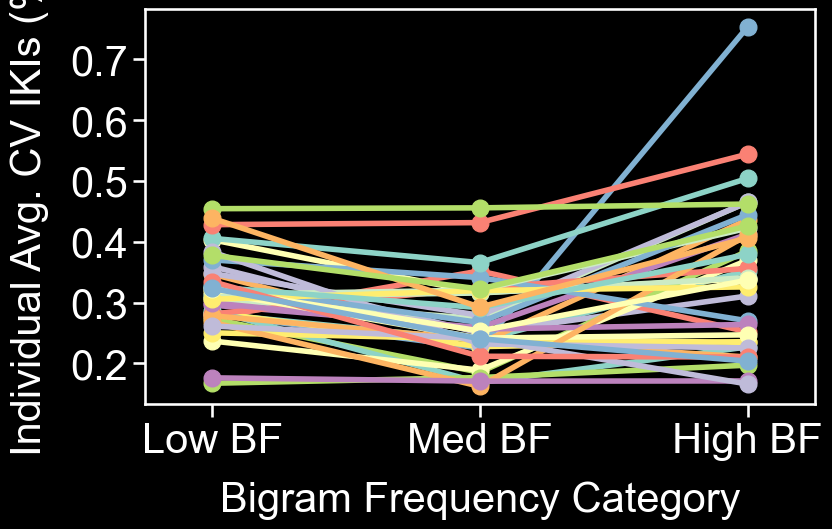

In [56]:
## Inividual MEAN CV IKIs by BF (all trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(all_bigrams, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(all_bigrams, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(all_bigrams, 'bigram', 'highbf')['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor='black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

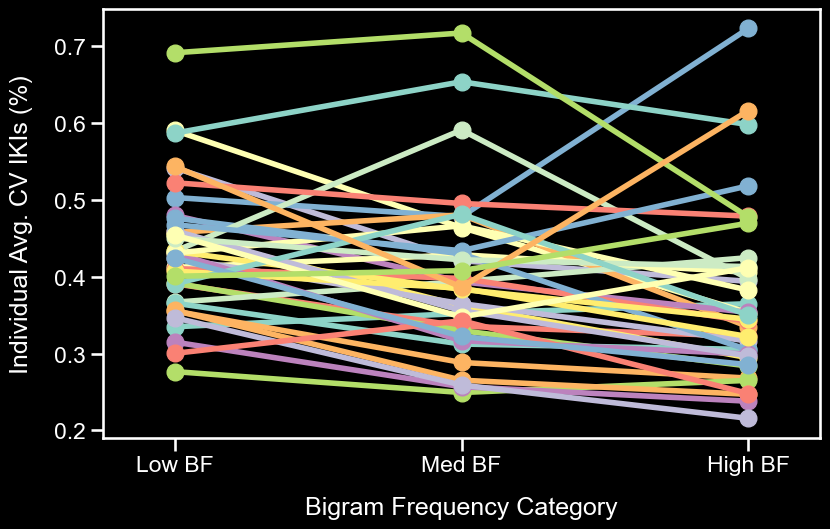

In [57]:
## Individual MEAN CV IKI by AVG BF category (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'string', 'avg_lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'string', 'avg_medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'string', 'avg_highbf')['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_cvikis_bybf.png', dpi=300, transparent = True)
plt.show()

In [58]:
# individual MEAN CV IKIs by AVG BF category (tight_bgs df)
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# x = [2, 4, 6]
# D = (indiv_cvikis(tight_bgs, 'string', 'avg_lowbf')['Avg CV IKI'], 
#      indiv_cvikis(tight_bgs, 'string', 'avg_medbf')['Avg CV IKI'], 
#      indiv_cvikis(tight_bgs, 'string', 'avg_highbf')['Avg CV IKI'])

# fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15)
# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_mean_ikis.png', dpi=300)
# plt.show()

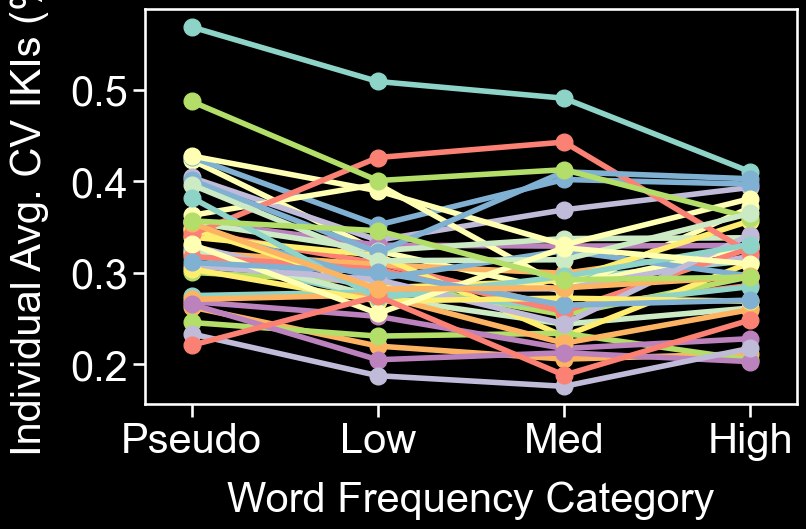

In [59]:
# individual avg CV IKI by WF category (can also change dataframe here)
x = [2, 4, 6, 8]
D = (indiv_cvikis(tight_bgs, 'string', 'pseudo')['Avg CV IKI'], 
     indiv_cvikis(tight_bgs, 'string', 'lowwf')['Avg CV IKI'], 
     indiv_cvikis(tight_bgs, 'string', 'medwf')['Avg CV IKI'],
     indiv_cvikis(tight_bgs, 'string', 'highwf')['Avg CV IKI'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), size=30)
plt.xlabel("Word Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKIs (%)", labelpad=15, size=30)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
# plt.savefig('indiv_mean_ikis.png', dpi=300)
plt.show()

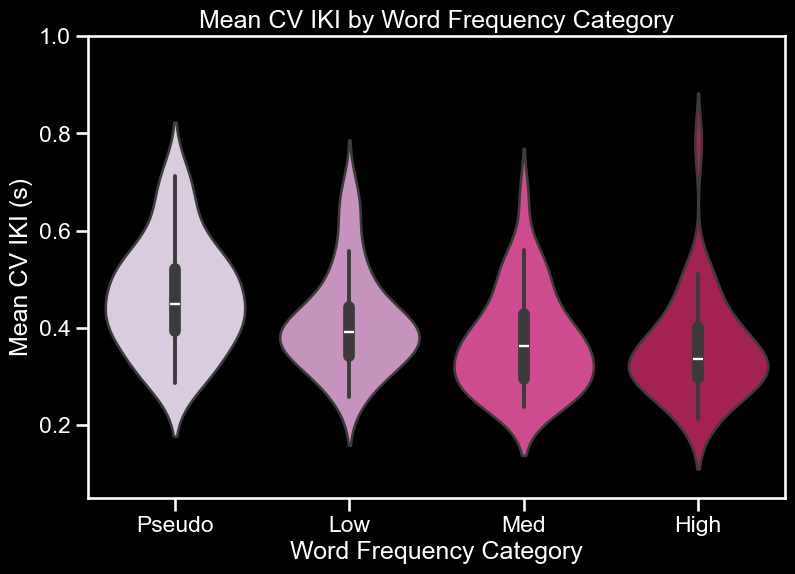

In [60]:
## mean CV IKI by WF (correct trials only)
data = {'Pseudo' : indiv_cvikis(corr_trials_bybg, 'string', 'pseudo')['Avg CV IKI'], 
        'Low': indiv_cvikis(corr_trials_bybg, 'string', 'lowwf')['Avg CV IKI'], 
        'Med' : indiv_cvikis(corr_trials_bybg, 'string', 'medwf')['Avg CV IKI'],
        'High' : indiv_cvikis(corr_trials_bybg, 'string', 'highwf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(0.05, 1)

plt.savefig('violin_meancvs_wf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

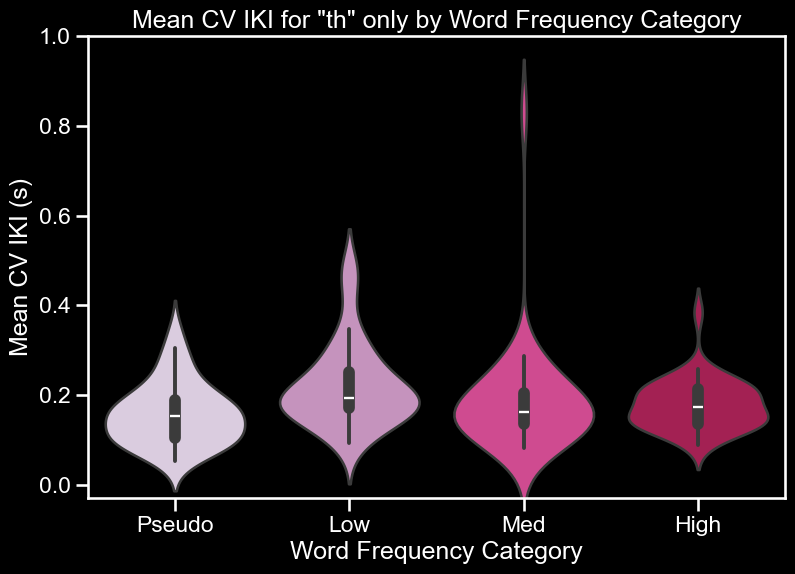

In [61]:
## Mean CV IKI for 'th' across WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_cvikis(th_df, 'string', 'pseudo')['Avg CV IKI'], 
        'Low': indiv_cvikis(th_df, 'string', 'lowwf')['Avg CV IKI'], 
        'Med' : indiv_cvikis(th_df, 'string', 'medwf')['Avg CV IKI'],
        'High' : indiv_cvikis(th_df, 'string', 'highwf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.03, 1)

plt.savefig('violin_meancvs_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

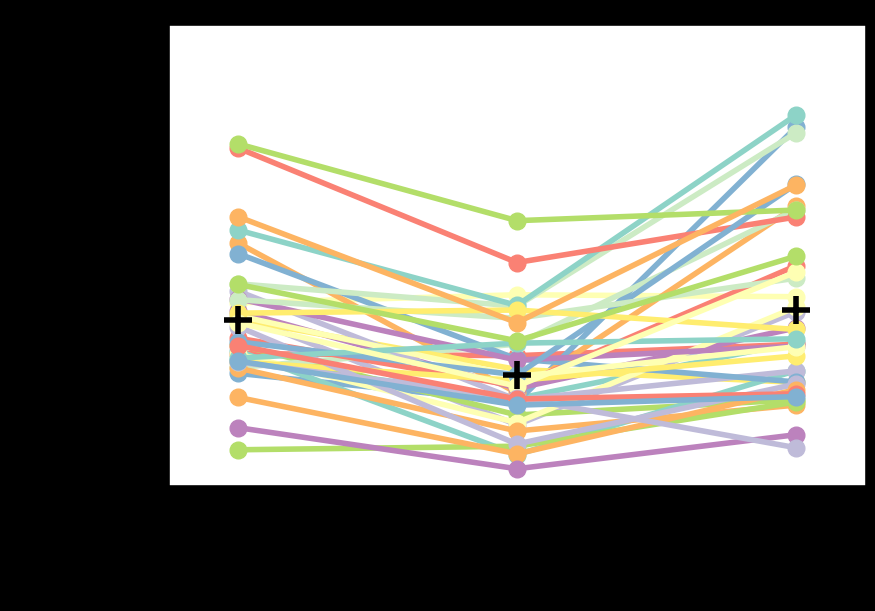

In [62]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'), size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Mean CV IKI (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

# Total Trial Error
___

## Total Trial Error Statistics

In [63]:
## anova for error rates (by bg freq)
all_errors_bybf = all_ikimetric(indiv_error, incorr_bgs, 
                                   'bigram', bf_groups)

print(pg.rm_anova(all_errors_bybf, 'Total Error', 'bf_type', 'sID'))

# pg.pairwise_tukey(all_errors_bybf, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     72  2.547467  0.085318   0.103096  0.022504  0.728648   

   sphericity   W-spher   p-spher  
0       False  0.627596  0.000288  


In [64]:
## anova for error rates (by avg bg freq)
all_errors_byavgbf = all_ikimetric(indiv_error, incorr_trials, 
                                   'string', avgbf_groups)

print(pg.rm_anova(all_errors_byavgbf, 'Total Error', 'avgbf_type', 'sID'))

pg.pairwise_tukey(all_errors_byavgbf, 'Total Error', 
                  'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2  \
0  avgbf_type      2     72  7.416892  0.001178   0.002775  0.061364   

        eps  sphericity   W-spher   p-spher  
0  0.797694       False  0.746387  0.005982  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  4.756757  7.135135 -2.378378  0.922474 -2.578259  0.030087   
1  high  med  4.756757  5.432432 -0.675676  0.922474 -0.732460  0.744797   
2   low  med  7.135135  5.432432  1.702703  0.922474  1.845799  0.159754   

      cohen  
0 -0.590727  
1 -0.189652  
2  0.397755

In [65]:
## anova for error rates (by word freq)
all_errors_bywf = all_ikimetric(indiv_error, incorr_trials, 
                                'string', wf_groups)

print(pg.rm_anova(all_errors_bywf, 'Total Error', 'wf_type', 'sID'))

pg.pairwise_tukey(all_errors_bywf, 'Total Error', 
                  'wf_type', effsize='cohen')

    Source  ddof1  ddof2        F     p-unc  p-GG-corr       ng2       eps  \
0  wf_type      3    108  2.91098  0.037805   0.050875  0.030106  0.791766   

   sphericity   W-spher   p-spher  
0       False  0.679477  0.019812  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  3.486486  4.675676 -1.189189  0.728268 -1.632899  0.363508   
1  high     med  3.486486  4.243243 -0.756757  0.728268 -1.039118  0.726772   
2  high  pseudo  3.486486  4.918919 -1.432432  0.728268 -1.966902  0.205409   
3   low     med  4.675676  4.243243  0.432432  0.728268  0.593782  0.933819   
4   low  pseudo  4.675676  4.918919 -0.243243  0.728268 -0.334002  0.987107   
5   med  pseudo  4.243243  4.918919 -0.675676  0.728268 -0.927784  0.790011   

      cohen  
0 -0.409447  
1 -0.252632  
2 -0.427069  
3  0.149436  
4 -0.074533  
5 -0.202001

## Trial Error Figures

(0      6
1     18
2     21
3     10
4      9
5     13
6      2
7      6
8     25
9      2
10     5
11     2
12    17
13     8
14    33
15    15
16     4
17     6
18    13
19     4
20    25
21    11
22    11
23    10
24    14
25     4
26    25
27     1
28     8
29    21
30    10
31     3
32    18
33     8
34    12
35    27
36    20
Name: Total Error, dtype: int64, 0      6
1     12
2     13
3     19
4     10
5     12
6      3
7     10
8     20
9      2
10     3
11     2
12    22
13    14
14    32
15    10
16     9
17     6
18    13
19     4
20    31
21     6
22     5
23    26
24    12
25     4
26    19
27     3
28    16
29    16
30    18
31     4
32    14
33     2
34     5
35    13
36    22
Name: Total Error, dtype: int64, 0      5
1      6
2     11
3      9
4     30
5      7
6     12
7     14
8     13
9      1
10     2
11     6
12    10
13     9
14    13
15     5
16     0
17     7
18     8
19     2
20    32
21    10
22     2
23    28
24     5
25    22
26     5
27     0
28    17
29    

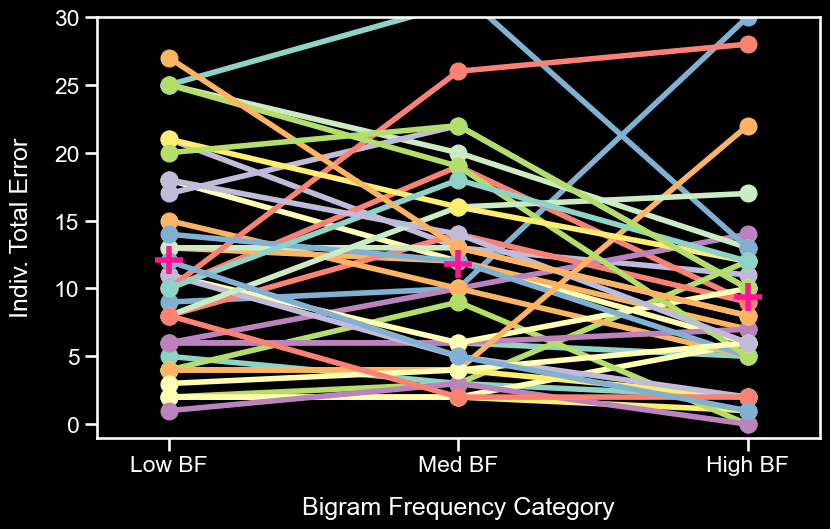

In [66]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', 'lowbf')['Total Error'], 
     indiv_error(incorr_bgs, 'bigram', 'medbf')['Total Error'],
     indiv_error(incorr_bgs, 'bigram', 'highbf')['Total Error'])

print(D)
means = (np.mean(indiv_error(incorr_bgs, 'bigram', 'lowbf')['Total Error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', 'medbf')['Total Error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', 'highbf')['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 30])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('meanerr_bybf.png', dpi=300)
plt.show()

In [67]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', 'avg_lowbf')['Total Error'], 
#      indiv_error(incorr_trials, 'string', 'avg_medbf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'avg_highbf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig('indiv_sdikis.png', dpi=300)
# plt.show()

In [68]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', 'pseudo')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'lowwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'medwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'highwf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig('indiv_sdikis.png', dpi=300)
# plt.show()

# Reaction Time

______

## Reaction Time Statistics

In [69]:
## finding indices of trials that occur after an error
err_indices = list(all_trials[all_trials['trial_corr'] == 'incorr'].index.values)
posterr_indices = list(map(lambda x: x + 1, err_indices))

## making dataframe of only post-error trial reaction times
all_rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
posterr_rts = all_rts.filter(posterr_indices, axis=0)

## making dataframe of only post-success trial reaction times
all_indices = list(all_trials.index.values)
bad_indices = (err_indices + posterr_indices)
postsucc_indices = list(filter(lambda x: x not in set(bad_indices), all_indices))
postsucc_rts = all_rts.filter(postsucc_indices, axis=0)

In [70]:
# Calculates individual mean reaction time (RT) across word frequency groups.
rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
indiv_meanrts = rts.groupby(['sID', 'wf_type']).mean().reset_index()
indiv_meanrts = indiv_meanrts.rename(columns={'key_resp.rt.1' : 'mean_RT'})

indiv_sdrts = rts.groupby(['sID', 'wf_type']).std().reset_index()
indiv_sdrts = indiv_sdrts.rename(columns={'key_resp.rt.1' : 'sd_RT'})

indiv_cvrts = rts.groupby(['sID', 'wf_type']).agg(variation).reset_index()
indiv_cvrts = indiv_cvrts.rename(columns={'key_resp.rt.1' : 'cv_RT'})

In [71]:
# Runs one-way, repeated measures ANOVA:
# individual mean RT | word frequency
print(pg.rm_anova(indiv_meanrts, 'mean_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(indiv_meanrts, 'mean_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2      eps
0  wf_type      3    108  100.028566  4.793127e-31  0.137372  0.63048


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.744101  0.804358 -0.060257  0.034144 -1.764802  0.294584   
1  highwf   medwf  0.744101  0.777278 -0.033178  0.034144 -0.971699  0.765752   
2  highwf  pseudo  0.744101  0.899317 -0.155216  0.034144 -4.545946  0.000067   
3   lowwf   medwf  0.804358  0.777278  0.027080  0.034144  0.793103  0.857484   
4   lowwf  pseudo  0.804358  0.899317 -0.094959  0.034144 -2.781145  0.030900   
5   medwf  pseudo  0.777278  0.899317 -0.122039  0.034144 -3.574248  0.002669   

      cohen  
0 -0.437389  
1 -0.260372  
2 -0.990010  
3  0.198803  
4 -0.578997  
5 -0.785219

In [72]:
# Runs one-way, repeated measures ANOVA:
# individual SD RT | word frequency
print(pg.rm_anova(indiv_sdrts, 'sd_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(indiv_sdrts, 'sd_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  12.163672  6.420221e-07  0.097355  0.812984


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.125311  0.139880 -0.014569  0.013401 -1.087162  0.697935   
1  highwf   medwf  0.125311  0.137663 -0.012352  0.013401 -0.921742  0.793270   
2  highwf  pseudo  0.125311  0.175456 -0.050145  0.013401 -3.741929  0.001487   
3   lowwf   medwf  0.139880  0.137663  0.002217  0.013401  0.165420  0.998383   
4   lowwf  pseudo  0.139880  0.175456 -0.035576  0.013401 -2.654767  0.043319   
5   medwf  pseudo  0.137663  0.175456 -0.037793  0.013401 -2.820186  0.027753   

      cohen  
0 -0.258004  
1 -0.228312  
2 -0.884407  
3  0.037852  
4 -0.583487  
5 -0.642874

In [73]:
# Runs one-way, repeated measures ANOVA:
# individual CV RT | word frequency
print(pg.rm_anova(indiv_cvrts, 'cv_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(indiv_cvrts, 'cv_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  wf_type      3    108  2.975354  0.034863  0.038017  0.829925


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  highwf   lowwf  0.164215  0.167759 -0.003544  0.012713 -0.278762  0.992408   
1  highwf   medwf  0.164215  0.173048 -0.008833  0.012713 -0.694809  0.898935   
2  highwf  pseudo  0.164215  0.192015 -0.027799  0.012713 -2.186728  0.131831   
3   lowwf   medwf  0.167759  0.173048 -0.005289  0.012713 -0.416047  0.975654   
4   lowwf  pseudo  0.167759  0.192015 -0.024255  0.012713 -1.907966  0.229267   
5   medwf  pseudo  0.173048  0.192015 -0.018966  0.012713 -1.491919  0.445023   

      cohen  
0 -0.064605  
1 -0.156128  
2 -0.527708  
3 -0.093432  
4 -0.460116  
5 -0.347975

## Reaction Time Figures

In [74]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (mean_rts[mean_rts['wf_type'] == 'pseudo']['mean_RT'],
    mean_rts[mean_rts['wf_type'] == 'lowwf']['mean_RT'],
    mean_rts[mean_rts['wf_type'] == 'medwf']['mean_RT'],
    mean_rts[mean_rts['wf_type'] == 'highwf']['mean_RT'])

means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['mean_RT']),
        np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['mean_RT']),
        np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['mean_RT']),
        np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['mean_RT']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

NameError: name 'mean_rts' is not defined

In [ ]:
## defining function to calculate delta onset delay
    
def deltaod(dataframe):
    # DF = dataframe.query('string == @string')
    dataframe = dataframe.rename(columns = {'key_resp.rt.1':'mean_RT'})
    deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).mean_RT.agg(['diff']))
    dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
    return dataframe

def indiv_meandeltaod(dataframe, sort_type):
    # DF = dataframe[dataframe['wf_type'] == sort_type]
    DF = dataframe[dataframe.string.isin(sort_type)]
    DF = deltaod(DF)
    mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
    mean_deltaods = mean_deltaods.rename(columns={'mean' : 'mean_deltaod'})
    return mean_deltaods

In [ ]:
## anova on delta onset delay comparisons across WF

deltaod_anova = pg.rm_anova(deltaod(corr_trials), 'delta_od', 'wf_type', 'sID')
print(deltaod_anova)
pg.pairwise_tukey(deltaod(corr_trials), 'delta_od', 'wf_type', effsize='cohen')

In [ ]:
deltaod_sds = deltaod(corr_trials).groupby('wf_type').delta_od.std()
print(deltaod_sds)
# deltaod(corr_trials)

In [ ]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod'],
    indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod'])

means = (np.mean(indiv_meandeltaod(corr_trials, typ.pseudo)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.lowwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.medwf)['mean_deltaod']),
        np.mean(indiv_meandeltaod(corr_trials, typ.highwf)['mean_deltaod']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Onset Delay (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaod_bywf.png', dpi=300)
plt.show()

In [ ]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo'].rename(columns = {'key_resp.rt.1':'mean_RT'})
pseudo_ods = pseudo_only.groupby(['sID', 'rep_num']).mean_RT.agg(['mean']).reset_index()

In [ ]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ods[pseudo_ods['rep_num'] == 0]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 1]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 2]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 3]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 4]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 5]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 6]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 7]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 8]['mean'],
    pseudo_ods[pseudo_ods['rep_num'] == 9]['mean'])

# means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
sns.lmplot(x="rep_num", y="mean", data=pseudo_ods)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

In [ ]:
## pearson correlation for 
print(pearsonr(pseudo_ods['mean'], pseudo_ods['rep_num']))

# Delta IKI

In [ ]:
# def indiv_cvs_bybg(string, bigram):
#     DF = tight_bgs.query('string == @string and bigram == @bigram')
#     cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
#     return cvs

## defining functions that calculate indivdual IKI means and Avg. CVS by word and bigram groupings

# def indiv_meanikis(dataframe, str_or_bg, sort_type): ## str_or_bg can be 'string' or 'bigram'
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     elif str_or_bg == 'bigram':
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg IKI'})
#     # means.columns = ['Avg IKI']
#     return means

# all_bigrams

# # def deltaiki(dataframe,):

# def deltaiki_bybg(dataframe, string, bigram):
#     DF = dataframe.query('string == @string and bigram == @bigram')
#     deltaikis = pd.DataFrame(DF.groupby('sID').IKI.agg(['diff'])).abs()
#     DF.insert(7, 'delta_iki', deltaikis)
#     # deltaikis.insert(0, 'sID', DF['sID'])
#     # for ID in ID_list:
#     #     deltaikis
#     # return DF.get_group('s210')
#     # return DF[DF.sID == 's209']
#     return DF
#     # return deltaikis
    
# # def indiv_deltaiki_bybg(dataframe, string, bigram):
# #     # DF = 
# #     DF = deltaiki_bybg(dataframe, string, bigram)
# #     DF = DF[DF.sID == sID].reset_index().drop(0)
# #     return DF

# # indiv_deltaiki_bybg('s209', all_bigrams, 'there', 'th')

# def deltaod(dataframe):
#     # DF = dataframe.query('string == @string')
#     dataframe = dataframe.rename(columns = {'key_resp.rt.1':'mean_RT'})
#     deltaods = pd.DataFrame(dataframe.groupby(['sID', 'string']).mean_RT.agg(['diff']))
#     dataframe.insert(len(dataframe.columns), 'delta_od', deltaods)
#     return dataframe

# def indiv_meandeltaod(dataframe, sort_type):
#     DF = dataframe[dataframe['wf_type'] == sort_type]
#     DF = deltaod(DF)
#     mean_deltaods = DF.groupby(['sID']).delta_od.agg(['mean']).reset_index()
#     return mean_deltaods

# def indiv_cvikis(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
#     avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean'])).reset_index().rename(columns = {'mean':'Avg CV IKI'})
#     # avg_cvs.columns = ['Avg CV IKI']
#     return avg_cvs

# def indiv_deltaikis(dataframe, str_or_bg, sort_type):
#     if str_or_bg == 'string':
#         DF = dataframe[dataframe.string.isin(sort_type)]
#     else:
#         DF = dataframe[dataframe.bigram.isin(sort_type)]
#     deltas = pd.DataFrame(DF.groupby(['sID', str_or_bg]).IKI.agg(['diff'])).abs().reset_index(drop=True)
#     deltas = deltas.rename(columns={'diff':'deltaiki'})
#     return deltas

def deltaiki(dataframe):
    # dataframe = dataframe.rename(columns = {'key_resp.rt.1':'mean_RT'})
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    deltaikis.fillna(0, inplace=True)
    if 'delta_iki' in dataframe.columns:
        dataframe.replace(dataframe['delta_iki'], deltaikis)
    else:
        dataframe.insert(len(dataframe.columns), 'delta_iki', deltaikis)
    return dataframe

def indiv_meandeltaiki(dataframe, str_or_bg, sort_type):
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(sort_type)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(sort_type)]
    else:
        print('use "string" or "bigram"')
    DF = deltaiki(DF)
    mean_deltaikis = DF.groupby(['sID']).delta_iki.agg(['mean']).reset_index()
    mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
    return mean_deltaikis

In [ ]:
test = deltaiki(corr_trials_bybg)
# test[test['rep_num'] == 0].sort_values(['trial_num'])
test[(test['sID'] == 's254') & (test['string'] == 'there') & (test['bigram'] == 'th')]

In [ ]:
indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)

In [ ]:
## anova on delta iki comparisons across WF
deltaiki_anova = pg.rm_anova(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', 'sID')
print(deltaiki_anova)
pg.pairwise_tukey(deltaiki(corr_trials_bybg.drop(9779)), 'delta_iki', 'wf_type', effsize='cohen')

In [ ]:
## plotting mean delta iki by WF group
# plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki'],
    indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki'])

means = (np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.pseudo)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.lowwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.medwf)['mean_deltaiki']),
        np.mean(indiv_meandeltaiki(corr_trials_bybg, 'string', typ.highwf)['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [ ]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['wf_type'] == 'pseudo']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()

In [ ]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

In [ ]:
def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([0,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'totaldelta_iki' in dataframe.columns:
        dataframe.replace(dataframe['totaldelta_iki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'totaldelta_iki', total_delta)
    return dataframe

In [ ]:
## calculating the total difference in IKI across all repetitions

totals = total_deltaiki(corr_trials_bybg)
last_trials = totals[totals['rep_num'] == 9]
mean_totaldeltas = last_trials.groupby(['sID', 'wf_type']).totaldelta_iki.agg(['mean']).reset_index()
mean_totaldeltas = mean_totaldeltas.rename(columns={'mean':'mean_totaldeltaiki'})

In [ ]:
test_totaldeltas = last_trials.groupby(['sID', 'bf_type']).totaldelta_iki.agg(['mean']).reset_index()
test_totaldeltas = test_totaldeltas.rename(columns={'mean':'mean_totaldeltaiki'})
# test_totaldeltas

totaldelta_anova = pg.rm_anova(test_totaldeltas, 'mean_totaldeltaiki', 'bf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(test_totaldeltas, 'mean_totaldeltaiki', 'bf_type', effsize='cohen')

In [ ]:
totaldelta_anova = pg.rm_anova(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', 'sID')
print(totaldelta_anova)
pg.pairwise_tukey(mean_totaldeltas, 'mean_totaldeltaiki', 'wf_type', effsize='cohen')

In [ ]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki'],
    mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki'])

means = (np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'pseudo']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'low']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'med']['mean_totaldeltaiki']),
        np.mean(mean_totaldeltas[mean_totaldeltas['wf_type'] == 'high']['mean_totaldeltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

In [ ]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
## Raster plot of indiv. MEAN IKI by BF

plt.figure(figsize=(10, 7))
highbf_scatter = plt.scatter([0] * len(indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI']), 
                              indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI'], 
                              label='High BF')
medbf_scatter = plt.scatter([1] * len(indiv_meanikis(all_bigrams, 'bigram', 'medbf')['Avg IKI']), 
                              indiv_meanikis(all_bigrams, 'bigram', 'medbf')['Avg IKI'], 
                              label='Med BF')
Lowbf_scatter = plt.scatter([2] * len(indiv_meanikis(all_bigrams, 'bigram', 'lowbf')['Avg IKI']), 
                              indiv_meanikis(all_bigrams, 'bigram', 'lowbf')['Avg IKI'], 
                              label='Low BF')

plt.xlabel("")
plt.ylabel("Avg IKI (s)")
plt.title("Individual Avg IKIs by BF")
plt.legend(loc= "best")

plt.show()

In [ ]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('think', 'th')['mean'], 
     indiv_meanikis_bybg('theme', 'th')['mean'], indiv_meanikis_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

# Repetition Effects

In [ ]:
## last rep - first rep IKI (effect of repetition on speed)
first_rep = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0].reset_index(drop=True)
first_rep = first_rep.sort_values(by=['sID', 'string', 'bigram_loc'])
last_rep = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9].reset_index(drop=True)
last_rep = last_rep.sort_values(by=['sID', 'string', 'bigram_loc'])

rep_effect = pd.concat([first_rep, last_rep])
rep_effect

iki_anova = pg.rm_anova(rep_effect, 'IKI', 'rep_num', 'sID')
print(iki_anova)

pg.pairwise_tukey(rep_effect, 'IKI', 'rep_num', effsize='cohen')

In [ ]:
pg.ttest(first_rep['IKI'], last_rep['IKI'])

In [ ]:
## plotting overall bg repetition effect
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('first_rep', 'last_rep')
D = (first_rep.IKI.mean(), last_rep.IKI.mean())
sds = (first_rep.IKI.std(), last_rep.IKI.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [ ]:
## repetition effect of high freq bgs
highbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_firstrep = highbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_lastrep = highbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highbf_diffs = (highbf_lastrep.IKI - highbf_firstrep.IKI)

## repetition effect of low freq bgs
lowbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_firstrep = lowbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_lastrep = lowbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowbf_diffs = (lowbf_lastrep.IKI - lowbf_firstrep.IKI)

pg.ttest(highbf_diffs, lowbf_diffs)

In [ ]:
## plotting repetition effect on high vs low freq bgs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high bf', 'low bf')
D = (highbf_diffs.mean(), lowbf_diffs.mean())
sds = (highbf_diffs.std(), lowbf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [ ]:
## repetition effect of high freq wfs
highwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_firstrep = highwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_lastrep = highwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highwf_diffs = (highwf_lastrep.IKI - highwf_firstrep.IKI).reset_index(drop=True)

## repetition effect of low freq wfs
lowwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_firstrep = lowwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_lastrep = lowwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowwf_diffs = (lowwf_lastrep.IKI - lowwf_firstrep.IKI).reset_index(drop=True)

pg.ttest(highwf_diffs, lowwf_diffs)

In [ ]:
## plotting repetition effect on high vs low freq wfs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high wf', 'low wf')
D = (highwf_diffs.mean(), lowwf_diffs.mean())
sds = (highwf_diffs.std(), lowwf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [ ]:
first_reps = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0].sort_values(by=['sID', 'string', 'bigram_loc'])
last_reps = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9].sort_values(by=['sID', 'string', 'bigram_loc'])

x = [(2, 4, 6, 8), (2, 4, 6, 8)]
D = (first_reps.groupby('bigram_loc').IKI.mean(),
     last_reps.groupby('bigram_loc').IKI.mean())

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
plt.show()

# Individual Differences

## Sensitivity to individual differences

In [ ]:
## calculating senstivity to individual differences (with weird metric I made up)
# D = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'), 
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

# high_bf

# np.mean(choose2(D['Avg IKI'], operation = abs_difference))
perms = list(it.permutations(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'], 2))
# for x in perms:
#     abs(x[1] - x[2])

sample_diffs = [abs(x[0] - x[1]) for x in perms]
indiv_sens = np.mean(sample_diffs)/np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'])
indiv_sens

In [ ]:
## Pearson correlation between low and high bigram freq. Mean IKIs
print(pearsonr(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
         indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

## Pearson correlation between low and high bigram freq. Mean SD IKIs
print(pearsonr(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI'], 
         indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI']))

## Pearson correlation between low and high bigram freq. Mean CV IKIs
print(pearsonr(indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
         indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']))

In [ ]:
## Pearson correlation between low and high word freq. Mean IKIs
print(pearsonr(indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'], 
         indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']))

## Pearson correlation between low and high word freq. Mean SD IKIs
print(pearsonr(indiv_sdikis(corr_trials_bybg, 'string', 'pseudo')['Avg SD IKI'], 
         indiv_sdikis(corr_trials_bybg, 'string', 'highwf')['Avg SD IKI']))

## Pearson correlation between low and high word freq. Mean SD IKIs
print(pearsonr(indiv_cvikis(corr_trials_bybg, 'string', 'pseudo')['Avg CV IKI'], 
         indiv_cvikis(corr_trials_bybg, 'string', 'highwf')['Avg CV IKI']))

In [ ]:
##plotting sd correlation
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI'], 
            indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI'], 
            s = 70, color = 'red')

z = np.polyfit(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI'], 
               indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')['Avg SD IKI'], 1)
p = np.poly1d(z)
plt.plot(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI'],
         p(indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg SD IKI']),
         color = 'red')

plt.xlabel("Mean SD IKI (Low)", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (High)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('SD_correlation_bysub', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

# GRAPHS
___

## Data Visualization
___

In [ ]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sns.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [ ]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

## BG FREQ GRAPHS
___

In [ ]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig('bf.png', dpi=300)
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Bigram-Word Interaction
___

In [ ]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('heond_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('think_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig('theme_dist.png', dpi=300, transparent = True)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with_onesub)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [ ]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [ ]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

In [ ]:
def wf_order_effects(bigram, first_wf, second_wf):
    b2b = pd.DataFrame()
    for sID in ID_list:
        DF = pd.DataFrame(corr_trials_bybg[(corr_trials_bybg['sID'] == sID) 
                          & (corr_trials_bybg['bigram'] == bigram)]).reset_index(drop=True)
        for index, data in enumerate(DF):
            if DF.loc[index, 'trial_num'] == DF.loc[index+1, 'trial_num'] - 1:
                if DF.loc[index, 'wf_type'] == first_wf and DF.loc[index+1, 'wf_type'] == second_wf:
                    # temp1 = pd.DataFrame(DF.loc[index]).T.reset_index(drop = True)
                    temp2 = pd.DataFrame(DF.loc[index+1]).T.reset_index(drop = True)
                    b2b = pd.concat([b2b, temp2])
    return b2b

In [ ]:
wf_order_effects('th', 'high', 'pseudo')

In [ ]:
def b2b_diff(wf1, wf2):
    DF = pd.concat([wf_order_effects('th', wf1, wf2), wf_order_effects('he', wf1, wf2)]) 
    ## only 'th' and 'he' are represnted across all WF groups
    diffs = pd.DataFrame(DF.IKI.diff()).reset_index(drop = True)
    diffs = diffs.iloc[1::2, :]
    diffs['comparison'] = (wf1 + ' to ' + wf2)
    return diffs

b2b_diff('high', 'pseudo')

In [ ]:
## anova for high to pseudo and high to high order effects on 'th' and 'he'
diffs = pd.concat([b2b_diff('pseudo', 'high'), 
                   b2b_diff('pseudo', 'med'), 
                   b2b_diff('pseudo', 'low'), 
                   b2b_diff('pseudo', 'pseudo')], ignore_index=True)
diffs['IKI'] = diffs['IKI'].astype('float64')

oe_anova = pg.anova(dv='IKI', data=diffs, between='comparison')
print(oe_anova)

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [ ]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig('ian_iki.png')

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Tables

In [ ]:
# Makes table of all individual speed and variability IKI metrics
all_ikimetrics = pd.concat([all_bybf, 
                            all_byavgbf, 
                            all_bywf]).reset_index(drop=True)

# Calculates frequency category means and SDs and collects into dataframe
table_dict = {}

for freq_type in ['bf_type', 'wf_type']:
    for freq in all_ikimetrics[freq_type].unique():
        if pd.isna(freq) == False:
            col_list = ['mean_IKI', 'sd_IKI', 'cv_IKI']
            value_list = []
            for col in col_list:
                metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean()
                metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std()
                value_list.append(("{} ± {}").format(metric_mean, 
                                                     metric_sd))
            table_dict[freq_type, freq] = value_list
   
table_dict
paper_table = pd.DataFrame().from_dict(table_dict)
paper_table.index = col_list
paper_table

In [ ]:
all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'].std()

In [ ]:
all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'].mean()

# Graveyard
___

# MRS Correlation
___

In [ ]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [ ]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_mean_rts = mean_rts[mean_rts.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_totaldeltaiki = mean_totaldeltas[mean_totaldeltas.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
allmean_GABA_totaldeltaiki = pd.DataFrame(GABA_totaldeltaiki.groupby('sID').mean_totaldeltaiki.agg('mean')).reset_index()

In [ ]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [ ]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [ ]:
GABA_quant_nofilt.groupby('voxel').mean(numeric_only=True).reset_index()

In [ ]:
A1_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
A2_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
both_meanGABA = GABA_quant_nofilt.groupby(['voxel']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
A1_FE = GABA_quant_nofilt.groupby(['voxel']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
A2_FE = GABA_quant_nofilt.groupby(['voxel']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
both_FE = GABA_quant_nofilt.groupby(['voxel']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

by_voxel = pd.concat([A1_meanGABA, 
                      A2_meanGABA['A2_meanGABA'], 
                      both_meanGABA['both_meanGABA'], 
                      A1_FE['A1_meanFE'], 
                      A2_FE['A2_meanFE'], 
                      both_FE['both_meanFE']], 
                      axis = 1)

L_thal_shims = {'A1_shims' : [17.6, 21.5, 19, 29, 17.4, 16.9, 20.6, 23.4, 22, 19.9], 
                'A2_ shims' : [float('nan'), 21.2, 18.8, 28.9, float('nan'), 16.8, 21.4, 22.4, 22, 20]}
Lthal_shims = pd.DataFrame(L_thal_shims).reset_index(drop = True)

only_Lthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'L_thal'].reset_index(drop = True)
only_Lthal = pd.concat([only_Lthal, Lthal_shims], axis = 1)
only_Lthal = only_Lthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')


R_thal_shims = {'A1_shims' : [18.9, 21.7, 18.3, 30.2, 18.1, 17.8, 19.1, 20.1, 24.3, 21.5],
                'A2_ shims' : [float('nan'), 20.7, 18.4, 31.2, float('nan'), 17.7, 19.8, 19.8, 23.1, 22]}
Rthal_shims = pd.DataFrame(R_thal_shims).reset_index(drop = True)
only_Rthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'R_thal'].reset_index(drop = True)
only_Rthal = pd.concat([only_Rthal, Rthal_shims], axis = 1)
only_Rthal = only_Rthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')

only_Rthal

# A1_meanGABA = only_thal.groupby(['sID']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
# A2_meanGABA = only_thal.groupby(['sID']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
# both_meanGABA = only_thal.groupby(['sID']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
# A1_FE = GABA_quant_nofilt.groupby(['sID']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
# A2_FE = GABA_quant_nofilt.groupby(['sID']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
# both_FE = GABA_quant_nofilt.groupby(['sID']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

# by_sID = pd.concat([A1_meanGABA, 
#                       A2_meanGABA['A2_meanGABA'], 
#                       both_meanGABA['both_meanGABA'], 
#                       A1_FE['A1_meanFE'], 
#                       A2_FE['A2_meanFE'], 
#                       both_FE['both_meanFE']], 
#                       axis = 1)

In [ ]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'pseudo']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'lowwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, list(typ.all_bigrams))['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', list(typ.all_bigrams))['mean_deltaiki'],
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'pseudo']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'low']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'med']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'high']['mean_totaldeltaiki'].reset_index(drop=True),
                     allmean_GABA_totaldeltaiki['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'pseudo_totaldeltaiki',
          'low_totaldeltaiki',
          'med_totaldeltaiki',
          'high_totaldeltaiki',
          'all_totaldeltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

In [ ]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [ ]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [ ]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [ ]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [ ]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

In [ ]:
GABA_df.pseudo_totaldeltaiki

In [ ]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high total delta iki')
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all total delta iki')
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

In [ ]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [ ]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [ ]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
R_allbf_means

In [ ]:
GABA_df.L_thal_GABA.dropna()

In [ ]:
## all bf mean IKIs against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_means, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_means, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf mean IKIs against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (all BFs)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig('RLthal_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = '17',loc="lower left", facecolor = 'black')

plt.savefig('RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# # plt.xlim([0.1, 0.12])
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig('LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all total delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Total Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI'], 
     indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI'],
     indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI']), 
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI']),
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig('F31_indiv_sdikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig('F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_sdikis(ten_sub, 'bigram', 'highbf')
high_sd['bf_type'] = 'high'
med_sd = indiv_sdikis(ten_sub, 'bigram', 'medbf_norep')
med_sd['bf_type'] = 'med'
low_sd = indiv_sdikis(ten_sub, 'bigram', 'lowbf_norep')
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')